# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (1er entrega)

## Fecha de entrega

20 de mayo de 2025

## Integrantes

* <Florencia, Ferreyra>
* <Jerónimo, Scafati>
* <Lara, Molina>
* <Stefano, Corzini>

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la funcion de ejemplo (`ruidoRosa_voss`).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar el notebook (.ipynb) (con las celdas ejecutas) y todos los archivos para reproducir los resultados por Slack.
* Todas las señales de audio deben ser generadas en formato .wav en una función nueva.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import soundfile as sf
import sounddevice as sd

## Función de sintetización de ruido rosa
El ruido rosa o ruido $\frac{1}{\sqrt{f}}$ , dónde $f$ denota frecuencia en Hz, es un ruido con una distribución de frecuencias tal que su densidad espectral de potencia es proporcional a la inversa de la frecuencia. Esto implica que su nivel, por bandas de tercio de octava, es constante. El nivel del ruido rosa por intervalo fijo de frecuencias va decayendo a razón de 3 dB/octava, de forma no lineal aunque las frecuencias se representan en un eje lineal.

![Espectro del ruido rosa](../img/image44.png)
<center><b>Fig 1.</b> Espectro del ruido rosa.</center>

Se adjunta a continuación una función que devuelva un ruido rosa sintetizado a partir del algoritmo de Voss y Clarke (pueden encontrar mas informacion en [este enlace](https://www.dsprelated.com/showabstract/3933.php) y en [este notebook](https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb)). 

**Consigna:** modificar la función original para que reciba como parametro la duración del ruido en segundos $t$ y como parametro opcional la frecuencia de muestreo $fs$ (Ayuda: la longitud de la señal sera el producto entre ambos). La función debe guardar el archivo de audio .wav de la señal generada y devolver el vector de datos de la señal.

In [8]:
def ruidoRosa_voss_editado(t, fs=44100, ncols=16):
    """
    Genera ruido rosa utilizando el algoritmo de Voss-McCartney.
    El algoritmo genera ruido rosa mezclando varias fuentes de números aleatorios, pero no todas cambian al mismo tiempo. Algunas cambian muy rápido (alta frecuencia), otras más lentamente (baja frecuencia).
    Así se logra que el resultado tenga más energía en bajas frecuencias, como el ruido rosa real.
    
    .. Nota:: si 'ruidoRosa.wav' existe, este será sobreescrito
    
    Parametros
    ----------
    t : float
        Valor temporal en segundos, este determina la duración del ruido generado.
    ncols: int
        Determina el número de fuentes a aleatorias a agregar.
    fs: int
        Frecuencia de muestreo en Hz de la señal. Por defecto el valor es 44100 Hz.
    
    returns: NumPy array
        Datos de la señal generada.
    
    Ejemplo
    -------
    Generar un `.wav` desde un numpy array de 10 segundos con ruido rosa a una 
    frecuencia de muestreo de 44100 Hz.
    
        import numpy as np
        import pandas as pd
        import soundfile as sf
        
        ruidoRosa_voss(10)
    """
    
    nrows = int(t * fs) # La longitud de la señal es el producto entre su duración en segundos, y cuántas muestras realiza por segundo (fs).

    array = np.full((nrows, ncols), np.nan) # Se crea una tabla de tamaño nrows (tiempo) × ncols (número de generadores). Todo se llena con NaN inicialmente.
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    n = nrows 
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0 
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n) # En esas posiciones [row, col], coloca un nuevo número aleatorio. Algunas columnas se actualizarán más que otras, para generar el ruido rosa.
    
    df = pd.DataFrame(array)
    filled = df.fillna(method='ffill', axis=0)
    total = filled.sum(axis=1) # Suma todas las filas, así se obtiene un vector de con el ruido rosa (de más a menos energía en frecuencias).
    
    ## Centrado de el array en 0
    total = total - total.mean() 
    
    ## Normalizado
    valor_max = max(abs(max(total)),abs(min(total)))
    total = total / valor_max
    
    sf.write('RuidoRosa.wav', total, fs)
    
    return total

Llamar la función.

In [9]:
ruidoRosa_voss_editado(10)

/tmp/ipykernel_18418/1328531241.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled = df.fillna(method='ffill', axis=0)


0         0.092910
1        -0.036787
2         0.051308
3        -0.015321
4         0.090262
            ...   
440995   -0.030648
440996    0.018010
440997   -0.101485
440998   -0.120532
440999    0.018126
Length: 441000, dtype: float64

Realizar una función para visualizar el dominio temporal de la señal.

In [10]:
def graficar_dominio_temporal(t, signal):
    """
    Grafica el dominio temporal de la señal
    
    Parámetros
    ----------
    señal : array
        Señal a graficar.
    fs : int
        Frecuencia de muestreo de la señal. Por defecto es 44100 Hz.
    
    returns: None
        Grafica la señal en el dominio temporal.
    
    Ejemplo
    -------
    Graficar el dominio temporal de una señal de ruido rosa.
    
        import numpy as np
        import matplotlib.pyplot as plt

        graficar_dominio_temporal(ruidoRosa_voss(10))
    """
    plt.figure(figsize=(10, 4))
    plt.plot(t, signal, color='m')
    plt.title('Señal en el dominio temporal')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.show()
    return None

Llamar a la función.

/tmp/ipykernel_18418/1328531241.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled = df.fillna(method='ffill', axis=0)


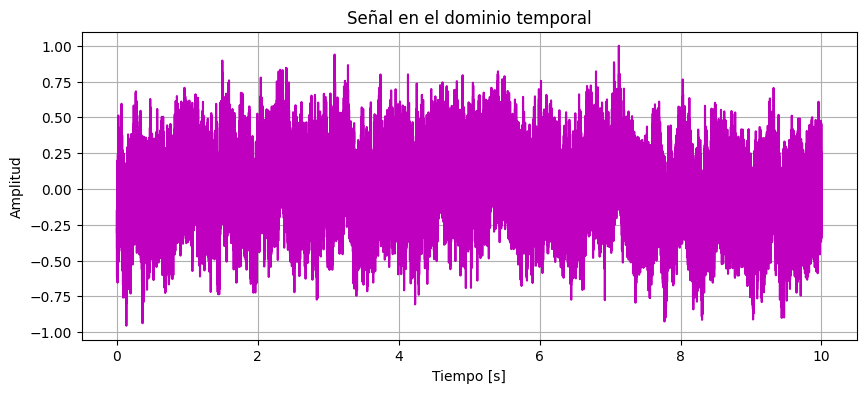

In [11]:
fs = 44100
signal = ruidoRosa_voss_editado(10)
t = np.arange(0, len(signal))/fs # Vector de tiempo

graficar_dominio_temporal(t, signal)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

![Espectro del ruido rosa](img/ruido_rosa.png)

*Espectro de frecuencias del ruido rosa*

Reproducir resultado.

In [6]:
sd.play(signal, fs)
sd.wait()

> Solo a modo de comentario, un **método alternativo** es utilizando un filtro en el siguiente [link](https://ccrma.stanford.edu/~jos/sasp/Example_Synthesis_1_F_Noise.html) se presenta la implementación en Matlab/Octave.

## Funcion de generación de sine sweep logaritmico + filtro inverso
El sine sweep es el método más indicado para generar el impulso por medio de la convolución (Nikolić, I., and O. H. Bjor, 2003). Dado que métodos tales como: explosión de globo, aplauso, disparo con pistola se salva, paper gun ([Paper Popper](https://en.wikipedia.org/wiki/Paper_popper)), golpe entre maderas, petardos, entre otros, carecen de reproducibilidad. Esto es debido a su nivel sonoro, duración y características espectrales, además de una muy baja relación señal ruido, la cual difícilmente se solucione filtrando o promediando con muchas mediciones. Comencemos por ver cómo generar el sine sweep logarítmico $x(t)$ que posee la siguiente forma:

\begin{equation}
f(x) = \sin[\theta(t)]= \sin[K (e^\frac{t}{L} - 1) ]
\tag{1}
\end{equation}

Donde:

\begin{equation}
K = \frac{T w_{1}}{R}
\end{equation}

\begin{equation}
L = \frac{T}{R}
\end{equation}

y el sweep rate $R$: 

\begin{equation}
R = \ln \left( \frac{w_{2}}{w_{1}} \right)
\tag{2}
\end{equation}

Con $w_{1}$ y $w_{2}$, las frecuencias angulares inferior y superior respectivamente, $T$ es el tiempo de duración del sine sweep en segundos (Meng, Q., 2008). Si estudiamos el espectro de la señal de la ecuación (1), se observa que no es plano, sino que disminuye a razón de -3 dB/octava, como el ruido rosa (Ver fig. 2, sup). De modo que el espectro de $x(-t)$ debe ser ajustado, aumentando en 3 dB/octava, de modo que cuando realizamos el cálculo se restaure la plenitud perfecta de la respuesta de impulso medida $h(t)$ (Farina A., 2000) (Ver fig. 2, inf).

![](../img/image43.png)
<center><b>Fig 2.</b> Espectro del sine sweep. Sine sweep logarítmico  (sup). Filtro invertido (inf).</center>


En el dominio temporal las señales del sine sweep logarítmico y el filtro inverso se comportan de la siguiente manera (Ver fig. 3). 

![](../img/image46.png)
<center><b>Fig 3.</b> Magnitud del sine sweep. Sine sweep logarítmico (sup). Filtro invertido (inf).</center>

Para generar el filtro inverso $k(t)$ del sine sweep logarítmico $x(t)$ se requiere de una modulación $m(t)$ definida por la siguiente expresión:

\begin{equation}
m(t) = \frac{w_{1}}{2\pi w(t)}
\tag{3}
\end{equation}

Obtenida de la frecuencia instantánea (dado que la amplitud cambia en función de la
frecuencia), calculada a partir de la ecuación (1):

\begin{equation}
w(t)=\frac{d[\theta (t)]}{dt}=\frac{K}{L} e^\frac{t}{L}
\tag{4}
\end{equation}
m
entonces, el filtro inverso $k(t)$ queda definido como:

\begin{equation}
k(t)=m(t)x(-t)
\tag{5}
\end{equation}

**Consigna:** realizar una función generadora de un sine sweep y su filtro inverso, a partir de las ecuaciones descriptas anteriormente, y graficar el resultado de ambos filtros, usando la función anteriormente creada. Recordar almacenar los audios. Agregar docstring que indique claramente los parametros de entrada y salida.

In [ ]:
def generar_sweep(duracion,fs=44100 ,f_inferior=20 ,f_superior=20000):
    """
    Genera un barrido logarítmico de frecuencias (sine sweep) entre f_inferior y f_superior.

    Parámetros
    ----------
    duracion : float
        Duración del barrido en segundos.
    fs : int, opcional
        Frecuencia de muestreo en Hz. Por defecto es 44100 Hz.
    f_inferior : float, opcional
        Frecuencia inferior del barrido en Hz. Por defecto es 20 Hz.
    f_superior : float, opcional
        Frecuencia superior del barrido en Hz. Por defecto es 20000 Hz.

    Returns
    -------
    sweep : np.ndarray
        Señal generada del barrido logarítmico normalizada.
    fs : int
        Frecuencia de muestreo utilizada.

    Ejemplo
    -------
    Generar un barrido logarítmico de frecuencias entre 20 Hz y 20000 Hz durante 10 segundos:

        sweep, fs = generar_sweep(10)
    """
    R = np.log(f_superior/f_inferior)
    muestras = int(duracion * fs)
    L = duracion/R
    K = L * 2 * np.pi * f_inferior

    #Generacion de vectores con numpy
    t = np.linspace(0, duracion, muestras, endpoint=False)
    sweep = np.sin(K * (np.exp(t/L) - 1 ))

    # Normalización, para evitar saturacion al reproducir
    sweep /= np.max(np.abs(sweep))

    # Guardar el barrido en un archivo WAV
    sf.write('sweep.wav', sweep, fs)

    return sweep

def generar_inverseSweep(duracion, fs=44100, f_inferior=20, f_superior=20000):
    """
    Genera un barrido logarítmico inverso de frecuencias (inverse sine sweep) entre f_inferior y f_superior.

    Parámetros
    ----------
    duracion : float
        Duración del barrido en segundos.
    fs : int, opcional
        Frecuencia de muestreo en Hz. Por defecto es 44100 Hz.
    f_inferior : float, opcional
        Frecuencia inferior del barrido en Hz. Por defecto es 20 Hz.
    f_superior : float, opcional
        Frecuencia superior del barrido en Hz. Por defecto es 20000 Hz.

    Returns
    -------
    inverse_sweep : np.ndarray
        Señal generada del barrido logarítmico inverso normalizada.
    fs : int
        Frecuencia de muestreo utilizada.

    Ejemplo
    -------
    Generar un barrido logarítmico inverso de frecuencias entre 20 Hz y 20000 Hz durante 10 segundos:

        inverse_sweep, fs = generar_inverseSweep(10)
    """
    
    R = np.log(f_superior/f_inferior)
    muestras = int(duracion * fs)
    L = duracion/R
    K = L * 2 * np.pi * f_inferior

    #Generacion de vectores con numpy
    t = np.linspace(0, duracion, muestras, endpoint=False)
    m_t = f_inferior/((K/L) *(np.exp(t/L)))
    x_t = np.sin(K * (np.exp(t/L) - 1 ))
    inverse_sweep = m_t* x_t[::-1]

    # Normalización, para evitar saturacion al reproducir
    inverse_sweep /= np.max(np.abs(inverse_sweep))

    # Guardar el barrido en un archivo WAV
    sf.write('inverse_sweep.wav', inverse_sweep, fs)

    return inverse_sweep


Llamar la función.

In [7]:
sweep = generar_sweep(10)     
inv_sweep = generar_inverseSweep(10)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

![Espectro sine sweep](img/sweep.png)

*Espectro de frecuencias del Sine Sweep*

![Espectro invert sweep](img/inverse_sweep.png)

*Espectro de frecuencias del filtro invertido*

Reproducir resultados.

In [9]:
sd.play(sweep, fs)
sd.wait()

sd.play(inv_sweep, fs)
sd.wait()

## Función adquisicion y reproducción
**Consigna**: la función tiene que permitir la reproducción y la adquisición de manera simultánea para un tiempo determinado por el usuario. Es importante evaluar y constatar dicha simultaneidad. El módulo debería permitir seleccionar el hardware a utilizar. Algunos articulos de interes para el desarrollo:
* [Clase de audio](../../clases/clase_6/600_audio.ipynb)
* [Sound Device - Simultaneous Playback and Recording](https://python-sounddevice.readthedocs.io/en/0.4.1/usage.html#simultaneous-playback-and-recording)
* [Playing and Recording Sound in Python](https://realpython.com/playing-and-recording-sound-python/)
* [Audio in Python](https://wiki.python.org/moin/Audio/)
* [https://github.com/spatialaudio/python-sounddevice/issues/148](https://github.com/spatialaudio/python-sounddevice/issues/148)

In [5]:
def grabar_reproducir(signal,fs=44100):
    """
    Reproduce una señal de audio y graba simultáneamente desde el dispositivo seleccionado.

    Parámetros
    ----------
    signal : np.ndarray
        Array 1D con la señal de audio a reproducir.
    fs : int, opcional
        Frecuencia de muestreo en Hz. Por defecto es 44100 Hz.

    Returns
    --------
    None
        La función guarda directamente el archivo de grabación con nombre "grabacion.wav".

    """
    print("Dispositivos disponibles: ")
    print(sd.query_devices()) # muestra los dispositivos disponibles

    dispositivo = int(input("Ingrese número de dispositivo: "))
    sd.default.device = dispositivo # se usa el dispositivo seleccionado como default
    sd.default.samplerate = fs # se determina la frecuncia de muestreo


    grabacion = sd.playrec(signal, samplerate=fs, channels=1) # reproduzco y grabo a la vez
    sd.wait()

    sf.write("grabacion.wav", grabacion, fs) #guardo la grabacion

Llamar la función.

In [6]:
t = 5
signal = generar_sweep(t)
grabar_reproducir(signal)

Dispositivos disponibles: 
   0 sof-hda-dsp: - (hw:0,0), ALSA (2 in, 2 out)
   1 sof-hda-dsp: - (hw:0,3), ALSA (0 in, 2 out)
   2 sof-hda-dsp: - (hw:0,4), ALSA (0 in, 2 out)
   3 sof-hda-dsp: - (hw:0,5), ALSA (0 in, 2 out)
   4 sof-hda-dsp: - (hw:0,6), ALSA (2 in, 0 out)
   5 sof-hda-dsp: - (hw:0,7), ALSA (2 in, 0 out)
   6 sysdefault, ALSA (128 in, 128 out)
   7 samplerate, ALSA (128 in, 128 out)
   8 speexrate, ALSA (128 in, 128 out)
   9 pulse, ALSA (32 in, 32 out)
  10 upmix, ALSA (8 in, 8 out)
  11 vdownmix, ALSA (6 in, 6 out)
  12 dmix, ALSA (0 in, 2 out)
* 13 default, ALSA (32 in, 32 out)


¿Cómo se podría medir la latencia de la función? Agregar un gráfico.

In [7]:
def medir_latencia(fs=44100, duracion=1.0):
    """
    Mide la latencia de reproducción y grabación de la función playrec de sounddevice.
    Se reproduce un impulso y se graba la señal de salida. Luego, se calcula la latencia.

    Parámetros
    ----------
    fs : int
        Frecuencia de muestreo en Hz. Por defecto es 44100 Hz.
    duracion : float
        Duración de la señal en segundos. Por defecto es 1 segundo.
    
    Returns
    -------     
    latencia_ms : float
        Latencia estimada en milisegundos.
    """
    # Crear un pulso (impulso en el tiempo)
    signal = np.zeros(int(fs * duracion))
    signal[100] = 1.0  # Impulso en la muestra 100
    signal = signal.reshape(-1, 1)  # Asegura forma (N, 1) para mono

    print("Reproduciendo y grabando...")
    grabacion = sd.playrec(signal, samplerate=fs, channels=1)
    sd.wait()

    # Procesamiento para encontrar la latencia
    grabado = grabacion.flatten()
    impulso_original = 100

    # Buscar el pico más grande en la grabación
    pico_grabado = np.argmax(np.abs(grabado))

    desfase_muestras = pico_grabado - impulso_original
    latencia_ms = (desfase_muestras / fs) * 1000

    print(f"Desfase: {desfase_muestras} muestras")
    print(f"Latencia estimada: {latencia_ms:.2f} ms")

    return latencia_ms